In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import lime
import lime.lime_tabular
import dice_ml


In [2]:
file_path = 'PIDDdiabetes.csv'  
diabetes_data = pd.read_csv(file_path)


critical_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
imputer = SimpleImputer(missing_values=0, strategy='median')
diabetes_data[critical_columns] = imputer.fit_transform(diabetes_data[critical_columns])

Q1 = diabetes_data['BMI'].quantile(0.25)
Q3 = diabetes_data['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
bmi_median = diabetes_data['BMI'].median()
diabetes_data['BMI'] = np.where((diabetes_data['BMI'] < lower_bound) | (diabetes_data['BMI'] > upper_bound), bmi_median, diabetes_data['BMI'])


In [3]:
scaler = StandardScaler()
X = diabetes_data.drop('Outcome', axis=1)
X[critical_columns] = scaler.fit_transform(X[critical_columns])

y = diabetes_data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Accuracy: 0.70

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.66      0.74       151
           1       0.55      0.79      0.65        80

    accuracy                           0.70       231
   macro avg       0.70      0.72      0.69       231
weighted avg       0.75      0.70      0.71       231



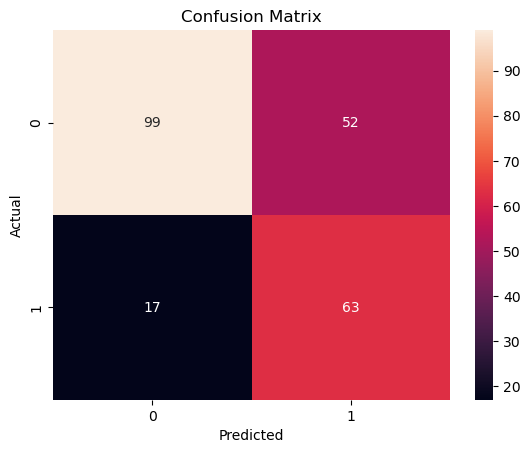

In [4]:
rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_balanced, y_train_balanced)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [5]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                        feature_names=X_train.columns, 
                                                        class_names=['No Diabetes', 'Diabetes'], 
                                                        mode='classification')
instance = X_test.iloc[0]
exp_lime = explainer_lime.explain_instance(instance.values, best_rf.predict_proba, num_features=5)
exp_lime.show_in_notebook(show_all=False)


C:\Users\SIU856559080\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [8]:
backend = 'sklearn'
m = dice_ml.Model(model=best_rf, backend=backend)
d = dice_ml.Data(dataframe=pd.concat([X, y], axis=1), continuous_features=X.columns.tolist(), outcome_name='Outcome')
exp_dice = dice_ml.Dice(d, m)

instance = X_test.iloc[0].to_frame().transpose()
dice_cf = exp_dice.generate_counterfactuals(instance, total_CFs=3, desired_class='opposite')
dice_cf.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

Query instance (original outcome : 1)


Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0          6.0 -0.777694       -1.19009       0.442995  0.571411  0.279977   

   DiabetesPedigreeFunction   Age  Outcome  
0                      0.43  43.0        1


Diverse Counterfactual set (new outcome: 0)


Pregnancies      Glucose BloodPressure SkinThickness     Insulin  \
0           -            -             -             -           -   
1           -  -1.71679903             -             -           -   
2           -            -             -             -  4.74192318   

            BMI DiabetesPedigreeFunction Age Outcome  
0  -1.549857653                        -   -     0.0  
1  -1.235352897                        -   -     0.0  
2  -1.087929811                        -   -     0.0

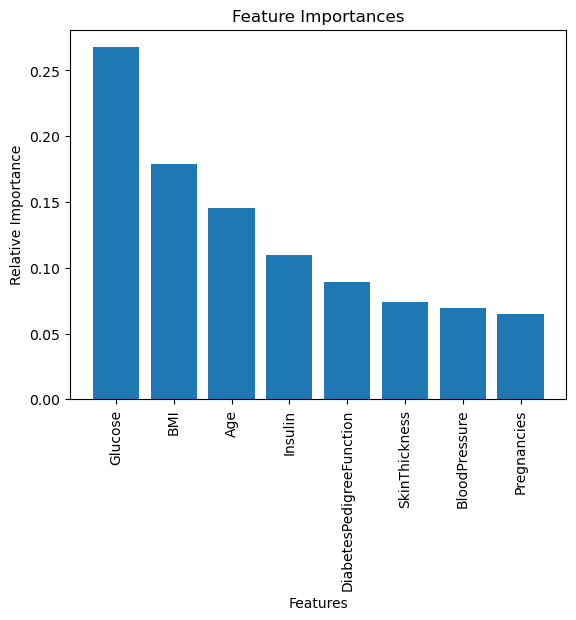

In [10]:
# Feature importance visualization
feature_importances = best_rf.feature_importances_
features = X_train.columns
indices = np.argsort(feature_importances)[::-1]
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.show()

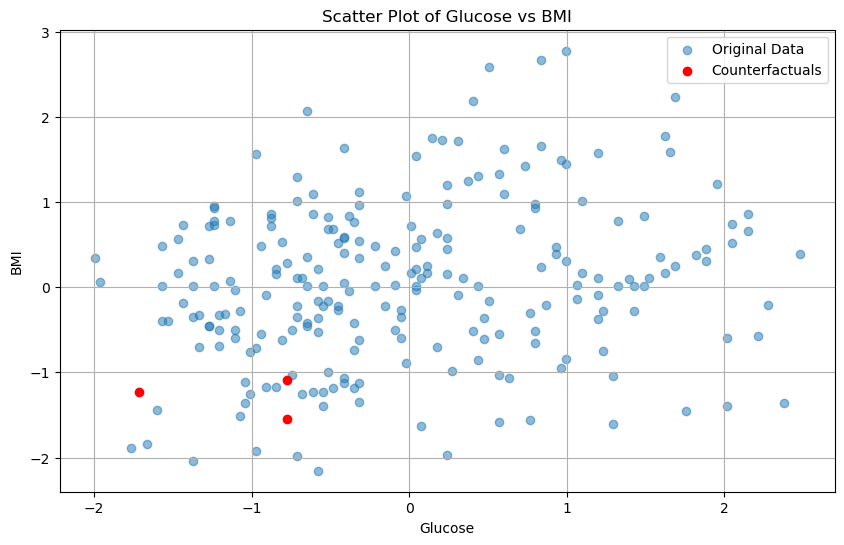

In [14]:
# Assuming counterfactuals are stored in 'dice_cf'
# Extracting the top two most important features for the scatter plot
top_features = [features[i] for i in indices[:2]]

# Extracting original and counterfactual data for these features
original_data = X_test[top_features].values
cf_data = dice_cf.cf_examples_list[0].final_cfs_df[top_features].values

# Scatter plot for counterfactuals
plt.figure(figsize=(10, 6))
plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.5, label='Original Data')
plt.scatter(cf_data[:, 0], cf_data[:, 1], color='red', label='Counterfactuals')

plt.title(f'Scatter Plot of {top_features[0]} vs {top_features[1]}')
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Python code to print a triangle shape using nested for loops

height = 6  # Height of the triangle

for i in range(1, 6):  # Outer loop for each row
    for k in range(i):  # Inner loop for printing stars
        print("*", end="")
    print()  # New line after each row


*
**
***
****
*****
